Step 1: Load and prepare data

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('crypto_data.csv')

# Calculate log changes (log-returns) for forecasting
df['Log_Close'] = np.log(df['Close'])
df['Log_Change'] = df['Log_Close'].diff()  # Target variable

# Drop NaN values that may appear due to diff()
df = df.dropna()

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Display first few rows
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,Log_Change
1,2019-01-01 00:15:00,3697.91,3698.75,3690.56,3694.20,131.742721,8.214519,-0.000842
2,2019-01-01 00:30:00,3693.96,3705.00,3693.00,3702.39,171.877714,8.216734,0.002215
3,2019-01-01 00:45:00,3702.05,3713.00,3695.02,3700.31,191.772890,8.216172,-0.000562
4,2019-01-01 01:00:00,3700.20,3702.73,3691.22,3701.03,139.872706,8.216366,0.000195
5,2019-01-01 01:15:00,3702.39,3702.39,3695.46,3699.25,135.318759,8.215885,-0.000481


Step 2: STL Decomposition

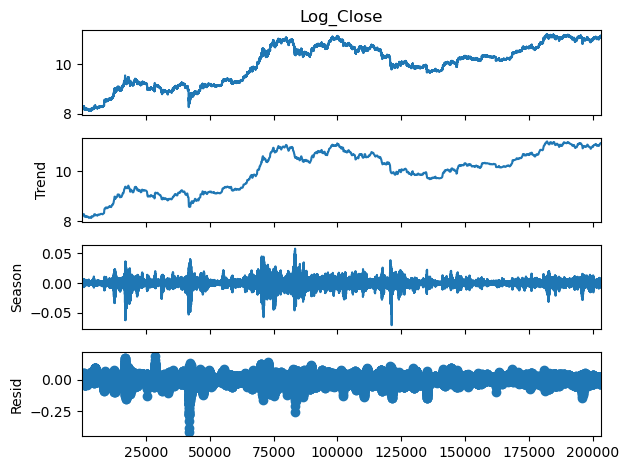

In [2]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def add_stl_features(df): 
    # STL decomposition
    seasonal_period = 96  # 15-minute intervals in a day (96 intervals in 24 hours)
    stl = STL(df['Log_Close'], period=seasonal_period, robust=True)
    result = stl.fit()

    # Add STL components to the dataframe
    df['STL_Trend'] = result.trend
    df['STL_Seasonal'] = result.seasonal
    df['STL_Residual'] = result.resid

    # Plot STL components
    result.plot()
    plt.show()

    return df

df = add_stl_features(df)

Step 3: Split data

In [3]:
train_start, train_end = '2019-01-02', '2024-01-01'
valid_start, valid_end = '2024-01-02', '2024-04-01'
predict_start, predict_end = '2024-04-02', '2024-10-20'

# Split the dataset
train_df = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
valid_df = df[(df['Timestamp'] >= valid_start) & (df['Timestamp'] <= valid_end)]
predict_df = df[(df['Timestamp'] >= predict_start) & (df['Timestamp'] <= predict_end)]

Step 4: Feature Engineering

In [4]:
def add_lag_features(df, lags):
    """
    Add lag-based features to the dataframe.
    Args:
        df (pd.DataFrame): Dataframe to add features to.
        lags (list): List of lag intervals.

    Returns:
        pd.DataFrame: Dataframe with additional features.
    """
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log(df['Close'] / 
                                             np.roll(df['Close'].rolling(lag).mean(), lag))
        df[f'log_return_{lag}'] = np.log(df['Close'] / np.roll(df['Close'], lag))

    for lag in lags:
        df[f'mean_close/mean_{lag}'] = df[[f'log_close/mean_{lag}']].mean(axis=1)
        df[f'mean_log_returns_{lag}'] = df[[f'log_return_{lag}']].mean(axis=1)
        
    for lag in lags:
        df[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = df[f'log_close/mean_{lag}'] - df[f'mean_close/mean_{lag}']
        df[f'log_return_{lag}-mean_log_returns_{lag}'] = df[f'log_return_{lag}'] - df[f'mean_log_returns_{lag}']

    return df

# Apply feature engineering to train, validation, and prediction sets
lags = [10, 20, 50]
train_df = add_lag_features(train_df, lags)
valid_df = add_lag_features(valid_df, lags)
predict_df = add_lag_features(predict_df, lags)

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_close/mean_{lag}'] = np.log(df['Close'] /
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_return_{lag}'] = np.log(df['Close'] / np.roll(df['Close'], lag))
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [5]:
def add_ta_features(df):
    """
    Add technical analysis (TA) features to a DataFrame.
    Args:
        df (pd.DataFrame): DataFrame with columns ['Close', 'High', 'Low'] (and optionally 'Volume']).
    
    Returns:
        pd.DataFrame: DataFrame with added TA features.
    """
    # Ensure Close, High, and Low columns exist
    if not all(col in df.columns for col in ['Close', 'High', 'Low']):
        raise ValueError("DataFrame must contain 'Close', 'High', and 'Low' columns.")
    
    # Relative Strength Index (RSI)
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period).mean()
        avg_loss = pd.Series(loss).rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Moving Average Convergence Divergence (MACD)
    def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
        ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
        ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        return macd, signal, histogram

    # Bollinger Bands
    def calculate_bollinger_bands(prices, period=20, num_std=2):
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (num_std * std)
        lower_band = sma - (num_std * std)
        return upper_band, sma, lower_band

    # Average True Range (ATR)
    def calculate_atr(high, low, close, period=14):
        tr = np.maximum.reduce([
            high - low,
            np.abs(high - close.shift(1)),
            np.abs(low - close.shift(1))
        ])
        atr = pd.Series(tr).rolling(window=period).mean()
        return atr

    # Exponential Moving Average (EMA)
    def calculate_ema(prices, period):
        return prices.ewm(span=period, adjust=False).mean()

    # Simple Moving Averages (SMA)
    def calculate_sma(prices, period):
        return prices.rolling(window=period).mean()

    # Stochastic Oscillator
    def calculate_stochastic_oscillator(close, high, low, period=14):
        lowest_low = low.rolling(window=period).min()
        highest_high = high.rolling(window=period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=3).mean()
        return k, d

    # On-Balance Volume (OBV)
    def calculate_obv(close, volume):
        return (np.sign(close.diff()) * volume).fillna(0).cumsum()

    # Average Directional Index (ADX)
    def calculate_adx(high, low, close, period=14):
        plus_dm = np.where(high.diff() > low.diff(), np.maximum(high.diff(), 0), 0)
        minus_dm = np.where(low.diff() > high.diff(), np.maximum(low.diff(), 0), 0)
        tr = np.maximum.reduce([
            high - low,
            np.abs(high - close.shift(1)),
            np.abs(low - close.shift(1))
        ])
        atr = pd.Series(tr).rolling(window=period).mean()
        plus_di = 100 * (pd.Series(plus_dm).rolling(window=period).mean() / atr)
        minus_di = 100 * (pd.Series(minus_dm).rolling(window=period).mean() / atr)
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = pd.Series(dx).rolling(window=period).mean()
        return adx, plus_di, minus_di

    # Add TA features to the DataFrame
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    df['EMA_50'] = calculate_ema(df['Close'], period=50)
    df['EMA_200'] = calculate_ema(df['Close'], period=200)
    df['ATR'] = calculate_atr(df['High'], df['Low'], df['Close'])
    df['SMA_20'] = calculate_sma(df['Close'], period=20)
    df['SMA_50'] = calculate_sma(df['Close'], period=50)
    df['Stochastic_%K'], df['Stochastic_%D'] = calculate_stochastic_oscillator(df['Close'], df['High'], df['Low'])
    df['OBV'] = calculate_obv(df['Close'], df['Volume'])
    df['ADX'], df['+DI'], df['-DI'] = calculate_adx(df['High'], df['Low'], df['Close'])

    # Return the DataFrame with added features
    return df

train_df = add_ta_features(train_df)
valid_df = add_ta_features(valid_df)
predict_df = add_ta_features(predict_df)

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\3897624095.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = calculate_rsi(df['Close'])
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\3897624095.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = calculate_macd(df['Close'])
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\3897624095.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Step 5: Train LightGBM Model

In [6]:
import lightgbm as lgb

# Define features and target variable
features = ['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
           [f'log_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}' for lag in lags] + \
           [f'mean_close/mean_{lag}' for lag in lags] + \
           [f'mean_log_returns_{lag}' for lag in lags] + \
           [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags] + \
           ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA_50', 'EMA_200', 'ATR', 
            'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 'ADX', '+DI', '-DI']


X_train = train_df[features]
y_train = train_df['Log_Change']

# Train LightGBM model
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, lgb_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


Step 6: Evaluate the model

RMSE: 0.0018
MAE: 0.0011
R^2 Score: 0.6668


<Figure size 1200x800 with 0 Axes>

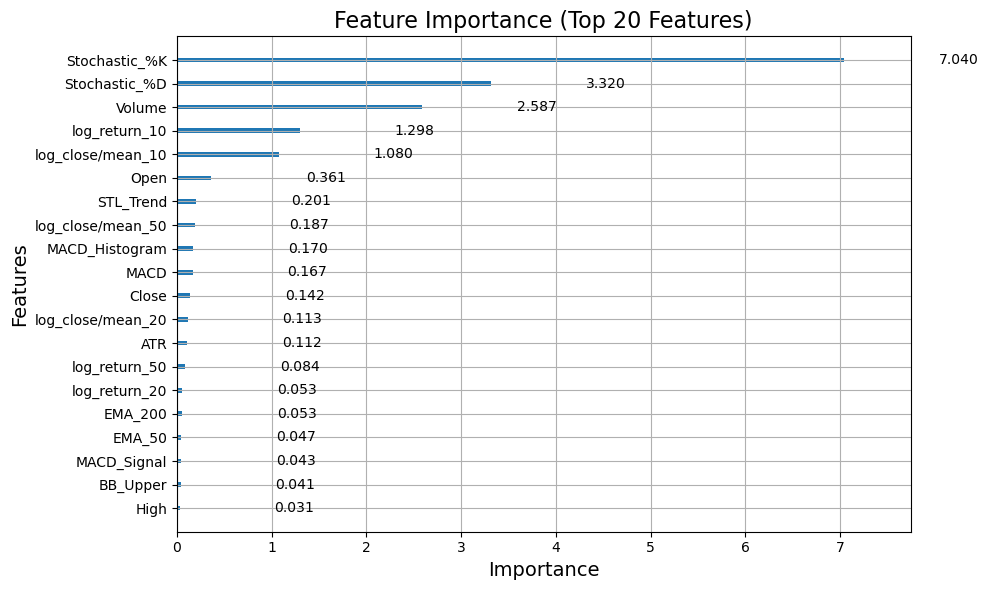

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on validation set
X_valid = valid_df[features]
y_valid = valid_df['Log_Change']
y_pred = lgb_model.predict(X_valid)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# Display metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Top 20 Features)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

Backtesting

In [8]:
X_predict = predict_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
           [f'log_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}' for lag in lags] + \
           [f'mean_close/mean_{lag}' for lag in lags] + \
           [f'mean_log_returns_{lag}' for lag in lags] + \
           [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags] + \
           ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA_50', 'EMA_200', 'ATR', 
            'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 'ADX', '+DI', '-DI']]
df_pred = predict_df.copy()
df_pred['Predict'] = lgb_model.predict(X_predict)

100%|██████████| 19297/19297 [00:01<00:00, 16812.92it/s]


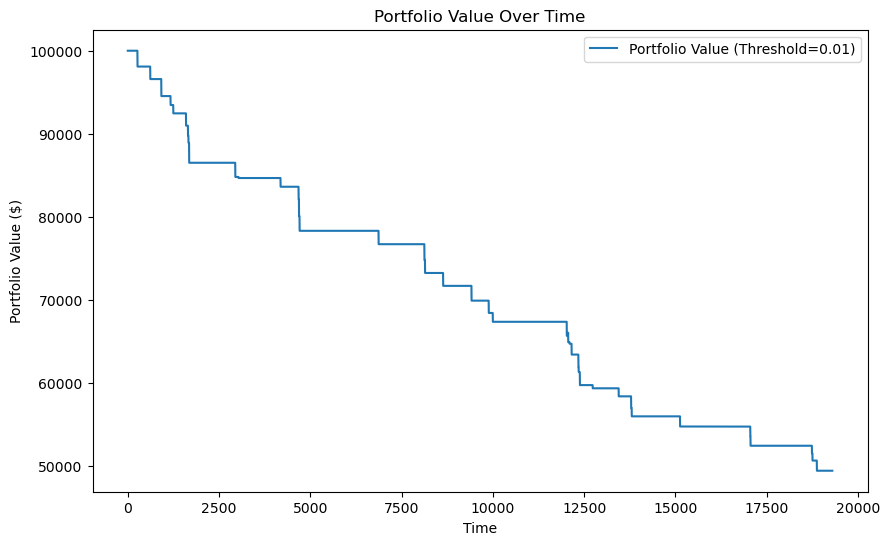

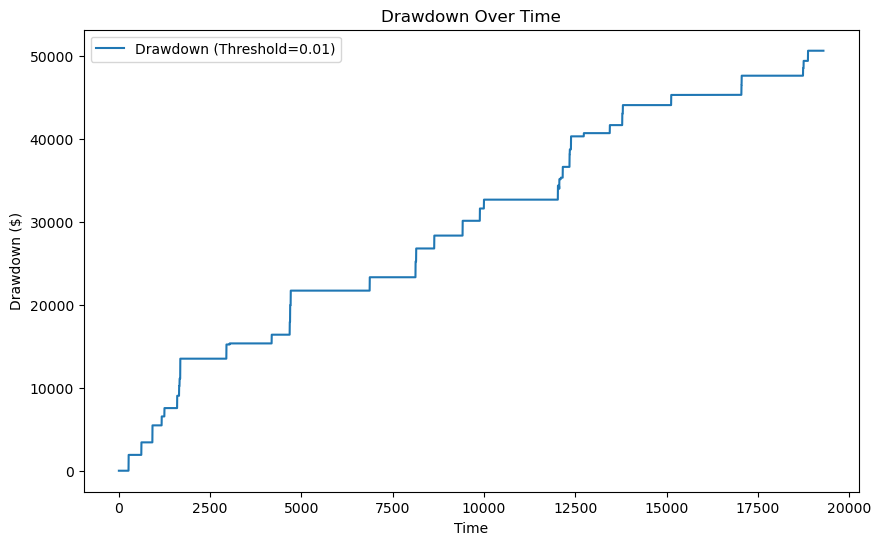

Backtesting Summary:
   threshold  total_profit  max_drawdown  trade_count  win_ratio  \
0       0.01    -50.613909     50.613909           42   0.047619   

   average_profit_per_trade  
0                 -1.205093  


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Enhanced function for backtesting
def backtest(df_pred, initial_balance=100000, trading_balance_ratio=1, threshold_values=[0.010], slippage=0.01):
    results = []
    for threshold in threshold_values:
        current_balance = initial_balance
        current_position = 0
        entry_price = 0
        trades = []
        portfolio_values = [initial_balance]
        peak_balance = initial_balance
        max_drawdown = 0
        win_trades = 0
        loss_trades = 0

        for i in tqdm(range(len(df_pred))):
            # Entry condition
            if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
                current_position = 1
                entry_price = df_pred.iloc[i]['Close']
                entry_time = df_pred.iloc[i]['Timestamp']
            # Exit condition
            elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
                exit_price = df_pred.iloc[i]['Close']
                trade_return = (exit_price * (1 - slippage) - entry_price * (1 + slippage)) / (entry_price * (1 + slippage))
                trade_profit = trade_return * current_balance * trading_balance_ratio
                current_balance += trade_profit
                trades.append({
                    "entry_price": entry_price,
                    "entry_time": entry_time,
                    "exit_price": exit_price,
                    "exit_time": df_pred.iloc[i]['Timestamp'],
                    "trade_return": trade_return,
                    "profit": trade_profit,
                })
                current_position = 0

                # Track wins and losses
                if trade_profit > 0:
                    win_trades += 1
                else:
                    loss_trades += 1

            portfolio_values.append(current_balance)
            peak_balance = max(peak_balance, current_balance)
            drawdown = (peak_balance - current_balance) / peak_balance * 100
            max_drawdown = max(max_drawdown, drawdown)

        total_profit = (current_balance - initial_balance) / initial_balance * 100
        results.append({
            "threshold": threshold,
            "total_profit": total_profit,
            "max_drawdown": max_drawdown,
            "trade_count": len(trades),
            "win_ratio": win_trades / len(trades) if trades else 0,
            "average_profit_per_trade": total_profit / len(trades) if trades else 0,
        })

        # Convert trades to DataFrame
        trades_df = pd.DataFrame(trades)

        # Plot portfolio value
        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_values, label=f'Portfolio Value (Threshold={threshold})')
        plt.xlabel('Time')
        plt.ylabel('Portfolio Value ($)')
        plt.title('Portfolio Value Over Time')
        plt.legend()
        plt.show()

        # Plot drawdown
        drawdown_values = [peak_balance - value for value in portfolio_values]
        plt.figure(figsize=(10, 6))
        plt.plot(drawdown_values, label=f'Drawdown (Threshold={threshold})')
        plt.xlabel('Time')
        plt.ylabel('Drawdown ($)')
        plt.title('Drawdown Over Time')
        plt.legend()
        plt.show()

    return pd.DataFrame(results), trades_df

# Backtesting results
results_df, trades_df = backtest(df_pred)
print("Backtesting Summary:")
print(results_df)

# Save trades to CSV for further analysis
trades_df.to_csv("trades_summary.csv", index=False)

In [10]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the feature columns you already created
features = ['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
           [f'log_close/mean_{lag}' for lag in [10, 20, 50]] + \
           [f'log_return_{lag}' for lag in [10, 20, 50]] + \
           [f'mean_close/mean_{lag}' for lag in [10, 20, 50]] + \
           [f'mean_log_returns_{lag}' for lag in [10, 20, 50]] + \
           [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in [10, 20, 50]] + \
           [f'log_return_{lag}-mean_log_returns_{lag}' for lag in [10, 20, 50]] + \
           ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA_50', 'EMA_200', 
            'ATR', 'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 'ADX', '+DI', '-DI']

# Define the Optuna objective function
def objective(trial):
    # Define the LightGBM hyperparameter space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
    }

    # Add feature engineering hyperparameters to the trial
    lags = trial.suggest_categorical('lags', [[10, 20, 50], [5, 10, 20], [20, 50, 100]])
    rsi_period = trial.suggest_int('rsi_period', 10, 50)
    macd_fast = trial.suggest_int('macd_fast', 5, 20)
    macd_slow = trial.suggest_int('macd_slow', 20, 50)

    # Relative Strength Index (RSI)
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period).mean()
        avg_loss = pd.Series(loss).rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Moving Average Convergence Divergence (MACD)
    def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
        ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
        ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        return macd, signal, histogram

    # Dynamic feature engineering
    def add_dynamic_features(df):
        # Add lag features
        df = add_lag_features(df, lags)
        # Add TA features with dynamic parameters
        df['RSI'] = calculate_rsi(df['Close'], period=rsi_period)
        df['MACD'], _, _ = calculate_macd(df['Close'], fast_period=macd_fast, slow_period=macd_slow)
        return df

    # Apply feature engineering to training and validation data
    train_data = add_dynamic_features(train_df.copy())
    valid_data = add_dynamic_features(valid_df.copy())

    # Prepare the data for LightGBM
    X_train = train_data[features]
    y_train = train_data['Log_Change']
    X_valid = valid_data[features]
    y_valid = valid_data['Log_Change']

    # Train LightGBM model
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
    model = lgb.train(params, dtrain, valid_sets=[dval])

    # Predict and evaluate
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)



[I 2024-12-07 14:50:19,140] A new study created in memory with name: no-name-fac1c73e-2dd0-49b2-93fd-83ea67dc6299
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:21,319] Trial 0 finished with value: 0.001815309995576094 and parameters: {'learning_rate': 0.01993666841048915, 'num_leaves': 149, 'max_depth': 44, 'min_data_in_leaf': 20, 'feature_fraction': 0.8931654333035368, 'bagging_fraction': 0.8416488886188196, 'bagging_freq': 6, 'lambda_l1': 0.001076534253365378, 'lambda_l2': 0.24975852843625898, 'lags': [10, 20, 50], 'rsi_period': 46, 'macd_fast': 17, 'macd_slow': 21}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9694
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 40
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:22,128] Trial 1 finished with value: 0.0026662191387736424 and parameters: {'learning_rate': 0.027729670321832517, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 18, 'feature_fraction': 0.6378936317125807, 'bagging_fraction': 0.6909337896296244, 'bagging_freq': 8, 'lambda_l1': 8.171908821438558, 'lambda_l2': 0.06669831695667795, 'lags': [10, 20, 50], 'rsi_period': 21, 'macd_fast': 8, 'macd_slow': 41}. Best is trial 0 with value: 0.001815309995576094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:22,919] Trial 2 finished with value: 0.003039971746057635 and parameters: {'learning_rate': 0.0012726796518631883, 'num_leaves': 200, 'max_depth': 18, 'min_data_in_leaf': 65, 'feature_fraction': 0.7146786886209946, 'bagging_fraction': 0.5786854593434617, 'bagging_freq': 5, 'lambda_l1': 7.371827445882778, 'lambda_l2': 0.4919579140833789, 'lags': [20, 50, 100], 'rsi_period': 17, 'macd_fast': 19, 'macd_slow': 38}. Best is trial 0 with value: 0.001815309995576094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:23,841] Trial 3 finished with value: 0.002951486235625332 and parameters: {'learning_rate': 0.0020390140304296827, 'num_leaves': 54, 'max_depth': 7, 'min_data_in_leaf': 53, 'feature_fraction': 0.8824348407431817, 'bagging_fraction': 0.5699900126793367, 'bagging_freq': 1, 'lambda_l1': 3.85954635062936, 'lambda_l2': 0.0016642827774897989, 'lags': [10, 20, 50], 'rsi_period': 40, 'macd_fast': 15, 'macd_slow': 27}. Best is trial 0 with value: 0.001815309995576094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:25,648] Trial 4 finished with value: 0.002590161629218703 and parameters: {'learning_rate': 0.006594000576969414, 'num_leaves': 181, 'max_depth': 40, 'min_data_in_leaf': 114, 'feature_fraction': 0.5002358580813626, 'bagging_fraction': 0.9265996787931825, 'bagging_freq': 1, 'lambda_l1': 0.006943989813232783, 'lambda_l2': 3.2644144722985633, 'lags': [20, 50, 100], 'rsi_period': 34, 'macd_fast': 9, 'macd_slow': 45}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:27,054] Trial 5 finished with value: 0.001997893309364531 and parameters: {'learning_rate': 0.033164944172873384, 'num_leaves': 57, 'max_depth': 40, 'min_data_in_leaf': 48, 'feature_fraction': 0.5387488610901241, 'bagging_fraction': 0.7509211390605477, 'bagging_freq': 10, 'lambda_l1': 0.12475269497674592, 'lambda_l2': 0.06489552735270991, 'lags': [5, 10, 20], 'rsi_period': 41, 'macd_fast': 20, 'macd_slow': 22}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:28,140] Trial 6 finished with value: 0.002711034833807677 and parameters: {'learning_rate': 0.005605041055068668, 'num_leaves': 45, 'max_depth': 21, 'min_data_in_leaf': 103, 'feature_fraction': 0.608574853030073, 'bagging_fraction': 0.581294568241105, 'bagging_freq': 5, 'lambda_l1': 0.41576208003213183, 'lambda_l2': 0.0020728989802267523, 'lags': [5, 10, 20], 'rsi_period': 29, 'macd_fast': 10, 'macd_slow': 37}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:29,312] Trial 7 finished with value: 0.002555854628646581 and parameters: {'learning_rate': 0.010141851784637107, 'num_leaves': 55, 'max_depth': 39, 'min_data_in_leaf': 73, 'feature_fraction': 0.5065493210722081, 'bagging_fraction': 0.7299015794311767, 'bagging_freq': 6, 'lambda_l1': 0.2642966880843062, 'lambda_l2': 8.69445234147595, 'lags': [5, 10, 20], 'rsi_period': 42, 'macd_fast': 18, 'macd_slow': 42}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:30,185] Trial 8 finished with value: 0.0027004231113366265 and parameters: {'learning_rate': 0.00738927988312558, 'num_leaves': 68, 'max_depth': 4, 'min_data_in_leaf': 58, 'feature_fraction': 0.6667315984915916, 'bagging_fraction': 0.6182542761229335, 'bagging_freq': 6, 'lambda_l1': 0.0010228474349066826, 'lambda_l2': 0.16080185489248916, 'lags': [10, 20, 50], 'rsi_period': 39, 'macd_fast': 7, 'macd_slow': 50}. Best is trial 0 with value: 0.001815309995576094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:30,925] Trial 9 finished with value: 0.00282704618279261 and parameters: {'learning_rate': 0.01455505528271829, 'num_leaves': 26, 'max_depth': 1, 'min_data_in_leaf': 55, 'feature_fraction': 0.896515040399596, 'bagging_fraction': 0.8361268439282614, 'bagging_freq': 8, 'lambda_l1': 0.1878830625474132, 'lambda_l2': 0.01286267726893203, 'lags': [10, 20, 50], 'rsi_period': 37, 'macd_fast': 13, 'macd_slow': 21}. Best is trial 0 with value: 0.001815309995576094.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:33,232] Trial 10 finished with value: 0.0016703052816425677 and parameters: {'learning_rate': 0.060830315256310455, 'num_leaves': 137, 'max_depth': 49, 'min_data_in_leaf': 197, 'feature_fraction': 0.9976011878384637, 'bagging_fraction': 0.9899886696535255, 'bagging_freq': 3, 'lambda_l1': 0.009293434064924895, 'lambda_l2': 1.0745704685759354, 'lags': [10, 20, 50], 'rsi_period': 50, 'macd_fast': 16, 'macd_slow': 30}. Best is trial 10 with value: 0.0016703052816425677.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:35,520] Trial 11 finished with value: 0.0016654329900643277 and parameters: {'learning_rate': 0.08047306786418096, 'num_leaves': 137, 'max_depth': 49, 'min_data_in_leaf': 186, 'feature_fraction': 0.9844627204820158, 'bagging_fraction': 0.9758390358137399, 'bagging_freq': 3, 'lambda_l1': 0.0061457955326835855, 'lambda_l2': 0.6222261357041248, 'lags': [10, 20, 50], 'rsi_period': 49, 'macd_fast': 16, 'macd_slow': 30}. Best is trial 11 with value: 0.0016654329900643277.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:37,614] Trial 12 finished with value: 0.0016679519834582434 and parameters: {'learning_rate': 0.09100778347535796, 'num_leaves': 114, 'max_depth': 49, 'min_data_in_leaf': 199, 'feature_fraction': 0.9975632363489525, 'bagging_fraction': 0.9849246714560004, 'bagging_freq': 3, 'lambda_l1': 0.013836812214044217, 'lambda_l2': 1.4310773031707917, 'lags': [10, 20, 50], 'rsi_period': 50, 'macd_fast': 14, 'macd_slow': 30}. Best is trial 11 with value: 0.0016654329900643277.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:39,715] Trial 13 finished with value: 0.0016537082351896141 and parameters: {'learning_rate': 0.09517797023500646, 'num_leaves': 117, 'max_depth': 30, 'min_data_in_leaf': 188, 'feature_fraction': 0.9781169550695006, 'bagging_fraction': 0.9990627884761392, 'bagging_freq': 3, 'lambda_l1': 0.01320675567476381, 'lambda_l2': 1.635676592988605, 'lags': [10, 20, 50], 'rsi_period': 50, 'macd_fast': 12, 'macd_slow': 31}. Best is trial 13 with value: 0.0016537082351896141.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:41,654] Trial 14 finished with value: 0.001700208057156626 and parameters: {'learning_rate': 0.04951218136831253, 'num_leaves': 102, 'max_depth': 31, 'min_data_in_leaf': 163, 'feature_fraction': 0.8096644109456698, 'bagging_fraction': 0.9074592293381949, 'bagging_freq': 3, 'lambda_l1': 0.0330553429703873, 'lambda_l2': 9.29807785573065, 'lags': [10, 20, 50], 'rsi_period': 24, 'macd_fast': 11, 'macd_slow': 32}. Best is trial 13 with value: 0.0016537082351896141.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:43,346] Trial 15 finished with value: 0.0016356315469887312 and parameters: {'learning_rate': 0.0976578324239289, 'num_leaves': 97, 'max_depth': 29, 'min_data_in_leaf': 160, 'feature_fraction': 0.8125045939287908, 'bagging_fraction': 0.8436432107741414, 'bagging_freq': 2, 'lambda_l1': 0.04740751839039951, 'lambda_l2': 1.6589370893895243, 'lags': [20, 50, 100], 'rsi_period': 11, 'macd_fast': 5, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:45,031] Trial 16 finished with value: 0.001717199952149398 and parameters: {'learning_rate': 0.040132477810303185, 'num_leaves': 96, 'max_depth': 29, 'min_data_in_leaf': 147, 'feature_fraction': 0.8048601847659235, 'bagging_fraction': 0.8316372700964504, 'bagging_freq': 2, 'lambda_l1': 0.0376406116706202, 'lambda_l2': 2.6444449659451337, 'lags': [20, 50, 100], 'rsi_period': 11, 'macd_fast': 6, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:46,406] Trial 17 finished with value: 0.0018212987932301247 and parameters: {'learning_rate': 0.09926381127539359, 'num_leaves': 84, 'max_depth': 29, 'min_data_in_leaf': 159, 'feature_fraction': 0.8027737142995351, 'bagging_fraction': 0.8969760124098729, 'bagging_freq': 4, 'lambda_l1': 0.6132783283427145, 'lambda_l2': 0.024038482728110808, 'lags': [20, 50, 100], 'rsi_period': 10, 'macd_fast': 5, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:48,170] Trial 18 finished with value: 0.0027186651765228895 and parameters: {'learning_rate': 0.003351161656407291, 'num_leaves': 126, 'max_depth': 15, 'min_data_in_leaf': 130, 'feature_fraction': 0.7385897212157574, 'bagging_fraction': 0.7856152216219427, 'bagging_freq': 2, 'lambda_l1': 0.03473680052091621, 'lambda_l2': 3.4098847964922876, 'lags': [20, 50, 100], 'rsi_period': 28, 'macd_fast': 12, 'macd_slow': 34}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:50,237] Trial 19 finished with value: 0.001802641081174454 and parameters: {'learning_rate': 0.024646653205710214, 'num_leaves': 153, 'max_depth': 33, 'min_data_in_leaf': 175, 'feature_fraction': 0.93535426426661, 'bagging_fraction': 0.6686334713715363, 'bagging_freq': 4, 'lambda_l1': 0.0037159638473600125, 'lambda_l2': 0.3708349579243037, 'lags': [20, 50, 100], 'rsi_period': 16, 'macd_fast': 5, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:50:51,275] Trial 20 finished with value: 0.002004305867074193 and parameters: {'learning_rate': 0.05586674060609443, 'num_leaves': 83, 'max_depth': 23, 'min_data_in_leaf': 138, 'feature_fraction': 0.8509736949907973, 'bagging_fraction': 0.5135320723970611, 'bagging_freq': 1, 'lambda_l1': 0.9068875065912193, 'lambda_l2': 1.2325359496438784, 'lags': [20, 50, 100], 'rsi_period': 33, 'macd_fast': 9, 'macd_slow': 34}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:53,329] Trial 21 finished with value: 0.0016614977505620303 and parameters: {'learning_rate': 0.07184794350812418, 'num_leaves': 119, 'max_depth': 36, 'min_data_in_leaf': 177, 'feature_fraction': 0.9523652033171301, 'bagging_fraction': 0.9474185090747995, 'bagging_freq': 2, 'lambda_l1': 0.003466793775838081, 'lambda_l2': 0.8010595849105149, 'lags': [10, 20, 50], 'rsi_period': 48, 'macd_fast': 15, 'macd_slow': 28}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:55,400] Trial 22 finished with value: 0.0016662952156965103 and parameters: {'learning_rate': 0.06553177450568749, 'num_leaves': 118, 'max_depth': 35, 'min_data_in_leaf': 172, 'feature_fraction': 0.9464652650946679, 'bagging_fraction': 0.9388143365521153, 'bagging_freq': 2, 'lambda_l1': 0.002820057174588003, 'lambda_l2': 4.154046632273118, 'lags': [10, 20, 50], 'rsi_period': 44, 'macd_fast': 13, 'macd_slow': 28}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:57,387] Trial 23 finished with value: 0.0016584747319231088 and parameters: {'learning_rate': 0.09859853649399394, 'num_leaves': 93, 'max_depth': 26, 'min_data_in_leaf': 183, 'feature_fraction': 0.9404880968332993, 'bagging_fraction': 0.8722427395491508, 'bagging_freq': 4, 'lambda_l1': 0.01939864726391301, 'lambda_l2': 0.8676097681086852, 'lags': [5, 10, 20], 'rsi_period': 46, 'macd_fast': 11, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:50:59,116] Trial 24 finished with value: 0.001722125816378715 and parameters: {'learning_rate': 0.04452801754395612, 'num_leaves': 93, 'max_depth': 26, 'min_data_in_leaf': 152, 'feature_fraction': 0.8447760337696758, 'bagging_fraction': 0.8700262474076411, 'bagging_freq': 4, 'lambda_l1': 0.0644403391040889, 'lambda_l2': 1.8589096699069032, 'lags': [5, 10, 20], 'rsi_period': 46, 'macd_fast': 11, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:00,697] Trial 25 finished with value: 0.0016515890695766055 and parameters: {'learning_rate': 0.09557469481511506, 'num_leaves': 79, 'max_depth': 26, 'min_data_in_leaf': 122, 'feature_fraction': 0.925479934339068, 'bagging_fraction': 0.7881985378906884, 'bagging_freq': 4, 'lambda_l1': 0.01806054082820774, 'lambda_l2': 0.1500670598188403, 'lags': [5, 10, 20], 'rsi_period': 26, 'macd_fast': 7, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:02,242] Trial 26 finished with value: 0.001756794340674334 and parameters: {'learning_rate': 0.03741938270080871, 'num_leaves': 76, 'max_depth': 15, 'min_data_in_leaf': 118, 'feature_fraction': 0.8409726129081466, 'bagging_fraction': 0.7910520251530732, 'bagging_freq': 5, 'lambda_l1': 0.08146027394931545, 'lambda_l2': 0.026049482863948453, 'lags': [5, 10, 20], 'rsi_period': 24, 'macd_fast': 7, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:03,470] Trial 27 finished with value: 0.0020956473381186116 and parameters: {'learning_rate': 0.017790759518905998, 'num_leaves': 35, 'max_depth': 25, 'min_data_in_leaf': 131, 'feature_fraction': 0.7783406000676808, 'bagging_fraction': 0.7860268924377822, 'bagging_freq': 7, 'lambda_l1': 0.015768060867811167, 'lambda_l2': 0.18891000203258065, 'lags': [5, 10, 20], 'rsi_period': 14, 'macd_fast': 7, 'macd_slow': 32}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:05,193] Trial 28 finished with value: 0.0016723996208340597 and parameters: {'learning_rate': 0.06411692853727607, 'num_leaves': 106, 'max_depth': 21, 'min_data_in_leaf': 98, 'feature_fraction': 0.9086654900223995, 'bagging_fraction': 0.7310947678540201, 'bagging_freq': 3, 'lambda_l1': 0.048259603188160013, 'lambda_l2': 0.131280641467001, 'lags': [20, 50, 100], 'rsi_period': 21, 'macd_fast': 5, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:07,297] Trial 29 finished with value: 0.0018051244516021324 and parameters: {'learning_rate': 0.02179805864311695, 'num_leaves': 156, 'max_depth': 28, 'min_data_in_leaf': 94, 'feature_fraction': 0.8775903593527958, 'bagging_fraction': 0.8179732947142024, 'bagging_freq': 2, 'lambda_l1': 0.02332622755328948, 'lambda_l2': 0.32851927374701073, 'lags': [5, 10, 20], 'rsi_period': 32, 'macd_fast': 9, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:09,500] Trial 30 finished with value: 0.0017230205139240429 and parameters: {'learning_rate': 0.03131236718458511, 'num_leaves': 167, 'max_depth': 43, 'min_data_in_leaf': 87, 'feature_fraction': 0.9086307067667367, 'bagging_fraction': 0.68044624874955, 'bagging_freq': 4, 'lambda_l1': 0.002354950182152127, 'lambda_l2': 0.003424471748474877, 'lags': [5, 10, 20], 'rsi_period': 25, 'macd_fast': 6, 'macd_slow': 32}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:11,238] Trial 31 finished with value: 0.001653839255681494 and parameters: {'learning_rate': 0.09023592559617773, 'num_leaves': 90, 'max_depth': 32, 'min_data_in_leaf': 187, 'feature_fraction': 0.9594472075404559, 'bagging_fraction': 0.870338925247728, 'bagging_freq': 4, 'lambda_l1': 0.016509213421253312, 'lambda_l2': 5.8669447072161525, 'lags': [5, 10, 20], 'rsi_period': 45, 'macd_fast': 12, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:13,131] Trial 32 finished with value: 0.0016734585171023673 and parameters: {'learning_rate': 0.07816561717834462, 'num_leaves': 72, 'max_depth': 33, 'min_data_in_leaf': 163, 'feature_fraction': 0.9721765639358675, 'bagging_fraction': 0.8646797352230539, 'bagging_freq': 5, 'lambda_l1': 0.009765941697601655, 'lambda_l2': 5.868207255422697, 'lags': [5, 10, 20], 'rsi_period': 21, 'macd_fast': 12, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:15,010] Trial 33 finished with value: 0.0017332795847967463 and parameters: {'learning_rate': 0.04793617907126581, 'num_leaves': 131, 'max_depth': 17, 'min_data_in_leaf': 188, 'feature_fraction': 0.922207777503008, 'bagging_fraction': 0.8068944514159343, 'bagging_freq': 3, 'lambda_l1': 0.10898282805958219, 'lambda_l2': 2.196182350578313, 'lags': [5, 10, 20], 'rsi_period': 37, 'macd_fast': 8, 'macd_slow': 27}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:16,955] Trial 34 finished with value: 0.00292690700852932 and parameters: {'learning_rate': 0.0010753085339897147, 'num_leaves': 107, 'max_depth': 32, 'min_data_in_leaf': 142, 'feature_fraction': 0.964874937345721, 'bagging_fraction': 0.7579684778290329, 'bagging_freq': 4, 'lambda_l1': 0.0017155404864413572, 'lambda_l2': 0.07628110523742086, 'lags': [5, 10, 20], 'rsi_period': 18, 'macd_fast': 10, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9694
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 40
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:18,499] Trial 35 finished with value: 0.0016608824600307952 and parameters: {'learning_rate': 0.07795001771752667, 'num_leaves': 86, 'max_depth': 36, 'min_data_in_leaf': 11, 'feature_fraction': 0.867698598737558, 'bagging_fraction': 0.8948977285313278, 'bagging_freq': 1, 'lambda_l1': 0.024824182089169144, 'lambda_l2': 5.866831846506911, 'lags': [20, 50, 100], 'rsi_period': 44, 'macd_fast': 14, 'macd_slow': 29}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:19,918] Trial 36 finished with value: 0.0016816805214714958 and parameters: {'learning_rate': 0.09835561490276869, 'num_leaves': 65, 'max_depth': 21, 'min_data_in_leaf': 38, 'feature_fraction': 0.96268757123869, 'bagging_fraction': 0.7118159996796602, 'bagging_freq': 6, 'lambda_l1': 0.006157883190292769, 'lambda_l2': 0.5059233206450612, 'lags': [5, 10, 20], 'rsi_period': 27, 'macd_fast': 8, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:21,535] Trial 37 finished with value: 0.0016870602102485887 and parameters: {'learning_rate': 0.053930229490968526, 'num_leaves': 100, 'max_depth': 11, 'min_data_in_leaf': 122, 'feature_fraction': 0.7131395487653434, 'bagging_fraction': 0.9586877444657427, 'bagging_freq': 10, 'lambda_l1': 0.05608424170717779, 'lambda_l2': 0.25899457356459904, 'lags': [20, 50, 100], 'rsi_period': 36, 'macd_fast': 6, 'macd_slow': 37}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:23,087] Trial 38 finished with value: 0.0017737700479454651 and parameters: {'learning_rate': 0.032528876900471855, 'num_leaves': 76, 'max_depth': 39, 'min_data_in_leaf': 167, 'feature_fraction': 0.7693672853300187, 'bagging_fraction': 0.8517882582029028, 'bagging_freq': 5, 'lambda_l1': 0.01056193211532761, 'lambda_l2': 0.038136869173611886, 'lags': [5, 10, 20], 'rsi_period': 31, 'macd_fast': 10, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:24,372] Trial 39 finished with value: 0.002865726944831246 and parameters: {'learning_rate': 0.0025828158147187985, 'num_leaves': 46, 'max_depth': 23, 'min_data_in_leaf': 155, 'feature_fraction': 0.6614745235119428, 'bagging_fraction': 0.9236332043655111, 'bagging_freq': 7, 'lambda_l1': 0.16250971904898046, 'lambda_l2': 6.4430474781403015, 'lags': [10, 20, 50], 'rsi_period': 43, 'macd_fast': 18, 'macd_slow': 27}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:51:25,415] Trial 40 finished with value: 0.002772215844440365 and parameters: {'learning_rate': 0.004070567430185194, 'num_leaves': 192, 'max_depth': 44, 'min_data_in_leaf': 109, 'feature_fraction': 0.8834051790567646, 'bagging_fraction': 0.6592921753882512, 'bagging_freq': 1, 'lambda_l1': 1.692772043359018, 'lambda_l2': 3.5175633092028584, 'lags': [5, 10, 20], 'rsi_period': 13, 'macd_fast': 14, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:27,143] Trial 41 finished with value: 0.0016603147246979956 and parameters: {'learning_rate': 0.09494114832494646, 'num_leaves': 89, 'max_depth': 26, 'min_data_in_leaf': 186, 'feature_fraction': 0.929871528383652, 'bagging_fraction': 0.8800391913732806, 'bagging_freq': 4, 'lambda_l1': 0.018135423516667425, 'lambda_l2': 0.8709573876048089, 'lags': [5, 10, 20], 'rsi_period': 47, 'macd_fast': 11, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:28,799] Trial 42 finished with value: 0.0016922261074275055 and parameters: {'learning_rate': 0.06981360398669041, 'num_leaves': 60, 'max_depth': 28, 'min_data_in_leaf': 182, 'feature_fraction': 0.9221173837295179, 'bagging_fraction': 0.7656862374549882, 'bagging_freq': 4, 'lambda_l1': 0.005018023775163873, 'lambda_l2': 1.757015232151592, 'lags': [5, 10, 20], 'rsi_period': 40, 'macd_fast': 12, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:30,410] Trial 43 finished with value: 0.001645011617103408 and parameters: {'learning_rate': 0.09883184403448504, 'num_leaves': 110, 'max_depth': 30, 'min_data_in_leaf': 193, 'feature_fraction': 0.5927229851428351, 'bagging_fraction': 0.8210131136025993, 'bagging_freq': 3, 'lambda_l1': 0.020311469900223082, 'lambda_l2': 0.8324950078354112, 'lags': [5, 10, 20], 'rsi_period': 47, 'macd_fast': 13, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:32,064] Trial 44 finished with value: 0.0016911756114571749 and parameters: {'learning_rate': 0.056416665755593086, 'num_leaves': 124, 'max_depth': 30, 'min_data_in_leaf': 194, 'feature_fraction': 0.5785729876136007, 'bagging_fraction': 0.8179842444243773, 'bagging_freq': 3, 'lambda_l1': 0.0082906483558481, 'lambda_l2': 0.49210747867554666, 'lags': [5, 10, 20], 'rsi_period': 48, 'macd_fast': 13, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:33,768] Trial 45 finished with value: 0.0022331385963358943 and parameters: {'learning_rate': 0.01122442540641435, 'num_leaves': 112, 'max_depth': 35, 'min_data_in_leaf': 200, 'feature_fraction': 0.6907039524261948, 'bagging_fraction': 0.8440722122016698, 'bagging_freq': 2, 'lambda_l1': 0.02563765518543796, 'lambda_l2': 0.006151062161121175, 'lags': [10, 20, 50], 'rsi_period': 45, 'macd_fast': 17, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-07 14:51:35,465] Trial 46 finished with value: 0.0016753254080921146 and parameters: {'learning_rate': 0.08239911368070761, 'num_leaves': 139, 'max_depth': 19, 'min_data_in_leaf': 192, 'feature_fraction': 0.6134624493542791, 'bagging_fraction': 0.7304795759308526, 'bagging_freq': 3, 'lambda_l1': 0.013428319790107475, 'lambda_l2': 1.3470550144959685, 'lags': [5, 10, 20], 'rsi_period': 42, 'macd_fast': 15, 'macd_slow': 41}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:37,008] Trial 47 finished with value: 0.0017968815968494795 and parameters: {'learning_rate': 0.04071209459815503, 'num_leaves': 103, 'max_depth': 37, 'min_data_in_leaf': 171, 'feature_fraction': 0.5758859413257457, 'bagging_fraction': 0.9237063327381132, 'bagging_freq': 9, 'lambda_l1': 0.042528331248800656, 'lambda_l2': 4.771758845932069, 'lags': [20, 50, 100], 'rsi_period': 50, 'macd_fast': 13, 'macd_slow': 49}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:38,633] Trial 48 finished with value: 0.001669921111651583 and parameters: {'learning_rate': 0.0657245709040187, 'num_leaves': 79, 'max_depth': 31, 'min_data_in_leaf': 72, 'feature_fraction': 0.986754879147673, 'bagging_fraction': 0.798668345551404, 'bagging_freq': 5, 'lambda_l1': 0.01303355827210447, 'lambda_l2': 2.5595320549497393, 'lags': [10, 20, 50], 'rsi_period': 35, 'macd_fast': 20, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:51:40,193] Trial 49 finished with value: 0.0017793174283243674 and parameters: {'learning_rate': 0.08098866059172563, 'num_leaves': 110, 'max_depth': 33, 'min_data_in_leaf': 178, 'feature_fraction': 0.8238664449906687, 'bagging_fraction': 0.7676724511431854, 'bagging_freq': 3, 'lambda_l1': 0.2622749945089452, 'lambda_l2': 8.487085646748282, 'lags': [5, 10, 20], 'rsi_period': 39, 'macd_fast': 16, 'macd_slow': 29}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:51:41,071] Trial 50 finished with value: 0.002577291642699501 and parameters: {'learning_rate': 0.049184736601943155, 'num_leaves': 142, 'max_depth': 23, 'min_data_in_leaf': 148, 'feature_fraction': 0.525572132339762, 'bagging_fraction': 0.9634926102068304, 'bagging_freq': 2, 'lambda_l1': 9.890101982564843, 'lambda_l2': 2.528271982138369, 'lags': [20, 50, 100], 'rsi_period': 48, 'macd_fast': 14, 'macd_slow': 31}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:43,007] Trial 51 finished with value: 0.0016481696753036959 and parameters: {'learning_rate': 0.09950866648220551, 'num_leaves': 98, 'max_depth': 27, 'min_data_in_leaf': 183, 'feature_fraction': 0.978909391998336, 'bagging_fraction': 0.9993475825077559, 'bagging_freq': 4, 'lambda_l1': 0.022038061026988465, 'lambda_l2': 0.786818729302117, 'lags': [5, 10, 20], 'rsi_period': 45, 'macd_fast': 11, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:45,183] Trial 52 finished with value: 0.0016578557230509745 and parameters: {'learning_rate': 0.08201760829430454, 'num_leaves': 98, 'max_depth': 28, 'min_data_in_leaf': 190, 'feature_fraction': 0.9985665654628574, 'bagging_fraction': 0.9961369998444025, 'bagging_freq': 5, 'lambda_l1': 0.07685587613101859, 'lambda_l2': 0.5705117987350966, 'lags': [5, 10, 20], 'rsi_period': 41, 'macd_fast': 12, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:47,371] Trial 53 finished with value: 0.0016572929673551945 and parameters: {'learning_rate': 0.06167779433280859, 'num_leaves': 128, 'max_depth': 30, 'min_data_in_leaf': 166, 'feature_fraction': 0.9792257603083463, 'bagging_fraction': 0.9791479811348429, 'bagging_freq': 3, 'lambda_l1': 0.026941675368426704, 'lambda_l2': 0.3388230314015742, 'lags': [5, 10, 20], 'rsi_period': 18, 'macd_fast': 10, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:49,321] Trial 54 finished with value: 0.0016404742904044106 and parameters: {'learning_rate': 0.09781089727436765, 'num_leaves': 115, 'max_depth': 41, 'min_data_in_leaf': 180, 'feature_fraction': 0.8959487436336986, 'bagging_fraction': 0.9097170478205479, 'bagging_freq': 4, 'lambda_l1': 0.0048561773290402505, 'lambda_l2': 0.11259828080608705, 'lags': [10, 20, 50], 'rsi_period': 45, 'macd_fast': 9, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:51,326] Trial 55 finished with value: 0.0016403657879650012 and parameters: {'learning_rate': 0.07186204310634293, 'num_leaves': 117, 'max_depth': 47, 'min_data_in_leaf': 158, 'feature_fraction': 0.8973350848871577, 'bagging_fraction': 0.8979517153063403, 'bagging_freq': 2, 'lambda_l1': 0.004867626893566925, 'lambda_l2': 0.10072218039379761, 'lags': [10, 20, 50], 'rsi_period': 50, 'macd_fast': 9, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:53,124] Trial 56 finished with value: 0.0016502647064180714 and parameters: {'learning_rate': 0.0720436252068846, 'num_leaves': 121, 'max_depth': 47, 'min_data_in_leaf': 157, 'feature_fraction': 0.8969221189012496, 'bagging_fraction': 0.9082544159030241, 'bagging_freq': 1, 'lambda_l1': 0.0017803454083258738, 'lambda_l2': 0.09565181997485817, 'lags': [10, 20, 50], 'rsi_period': 47, 'macd_fast': 9, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:54,917] Trial 57 finished with value: 0.0016530657567978898 and parameters: {'learning_rate': 0.07179846169202042, 'num_leaves': 123, 'max_depth': 45, 'min_data_in_leaf': 158, 'feature_fraction': 0.8681899389798877, 'bagging_fraction': 0.909292212557004, 'bagging_freq': 1, 'lambda_l1': 0.0016234207592039065, 'lambda_l2': 0.044933461440685746, 'lags': [10, 20, 50], 'rsi_period': 48, 'macd_fast': 8, 'macd_slow': 27}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:56,997] Trial 58 finished with value: 0.00286120815867833 and parameters: {'learning_rate': 0.0016087724353562743, 'num_leaves': 134, 'max_depth': 47, 'min_data_in_leaf': 142, 'feature_fraction': 0.9004751721780674, 'bagging_fraction': 0.8889653382985349, 'bagging_freq': 1, 'lambda_l1': 0.0013838452716841312, 'lambda_l2': 0.09592752934960981, 'lags': [10, 20, 50], 'rsi_period': 43, 'macd_fast': 9, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:51:58,951] Trial 59 finished with value: 0.0017844924718194632 and parameters: {'learning_rate': 0.027462626341557377, 'num_leaves': 117, 'max_depth': 40, 'min_data_in_leaf': 173, 'feature_fraction': 0.7940202646433776, 'bagging_fraction': 0.9371492672535304, 'bagging_freq': 2, 'lambda_l1': 0.004664172528746682, 'lambda_l2': 0.0010229364193305682, 'lags': [10, 20, 50], 'rsi_period': 47, 'macd_fast': 9, 'macd_slow': 28}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:01,323] Trial 60 finished with value: 0.0016725105077331555 and parameters: {'learning_rate': 0.05743636187993117, 'num_leaves': 149, 'max_depth': 42, 'min_data_in_leaf': 181, 'feature_fraction': 0.8316853234170867, 'bagging_fraction': 0.9079238156098756, 'bagging_freq': 2, 'lambda_l1': 0.004044118324381741, 'lambda_l2': 0.0575389313662595, 'lags': [10, 20, 50], 'rsi_period': 50, 'macd_fast': 10, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:03,028] Trial 61 finished with value: 0.0016402919843168746 and parameters: {'learning_rate': 0.09915374166472585, 'num_leaves': 110, 'max_depth': 50, 'min_data_in_leaf': 149, 'feature_fraction': 0.857204352358576, 'bagging_fraction': 0.8332380883588112, 'bagging_freq': 1, 'lambda_l1': 0.0025149306347355804, 'lambda_l2': 0.11468190479323628, 'lags': [10, 20, 50], 'rsi_period': 46, 'macd_fast': 6, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:04,708] Trial 62 finished with value: 0.0016590259293572866 and parameters: {'learning_rate': 0.07170329733009877, 'num_leaves': 111, 'max_depth': 48, 'min_data_in_leaf': 152, 'feature_fraction': 0.8531589545433613, 'bagging_fraction': 0.823616278132618, 'bagging_freq': 1, 'lambda_l1': 0.0022528075749420054, 'lambda_l2': 0.20229178932830422, 'lags': [10, 20, 50], 'rsi_period': 45, 'macd_fast': 8, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:06,288] Trial 63 finished with value: 0.001651004687207421 and parameters: {'learning_rate': 0.08558767243424774, 'num_leaves': 103, 'max_depth': 46, 'min_data_in_leaf': 133, 'feature_fraction': 0.8238977128867776, 'bagging_fraction': 0.8519974646456129, 'bagging_freq': 1, 'lambda_l1': 0.0012889340864374412, 'lambda_l2': 0.09230917763875049, 'lags': [10, 20, 50], 'rsi_period': 46, 'macd_fast': 5, 'macd_slow': 44}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:08,161] Trial 64 finished with value: 0.0023460603332677095 and parameters: {'learning_rate': 0.007881816888685056, 'num_leaves': 123, 'max_depth': 50, 'min_data_in_leaf': 161, 'feature_fraction': 0.7492568267191159, 'bagging_fraction': 0.8339526428145037, 'bagging_freq': 2, 'lambda_l1': 0.0010097438542048043, 'lambda_l2': 0.12871289748957426, 'lags': [10, 20, 50], 'rsi_period': 49, 'macd_fast': 6, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:10,259] Trial 65 finished with value: 0.0016904736227570708 and parameters: {'learning_rate': 0.04390736465056835, 'num_leaves': 116, 'max_depth': 42, 'min_data_in_leaf': 168, 'feature_fraction': 0.8919307263658585, 'bagging_fraction': 0.9623696679822267, 'bagging_freq': 2, 'lambda_l1': 0.0023098585753022335, 'lambda_l2': 0.026980805298948377, 'lags': [10, 20, 50], 'rsi_period': 43, 'macd_fast': 7, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:11,860] Trial 66 finished with value: 0.0016441886112483607 and parameters: {'learning_rate': 0.09957326138453618, 'num_leaves': 96, 'max_depth': 48, 'min_data_in_leaf': 177, 'feature_fraction': 0.8602736842047259, 'bagging_fraction': 0.8603607687810403, 'bagging_freq': 1, 'lambda_l1': 0.002985879661293381, 'lambda_l2': 0.24681884374480556, 'lags': [10, 20, 50], 'rsi_period': 41, 'macd_fast': 9, 'macd_slow': 29}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:13,715] Trial 67 finished with value: 0.0016610325974057171 and parameters: {'learning_rate': 0.08810669751793149, 'num_leaves': 99, 'max_depth': 46, 'min_data_in_leaf': 174, 'feature_fraction': 0.8573300322611143, 'bagging_fraction': 0.8561058332077016, 'bagging_freq': 2, 'lambda_l1': 0.006712885700909998, 'lambda_l2': 0.2437452224998354, 'lags': [10, 20, 50], 'rsi_period': 38, 'macd_fast': 11, 'macd_slow': 29}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:15,467] Trial 68 finished with value: 0.0016823427740356614 and parameters: {'learning_rate': 0.0528649609081237, 'num_leaves': 95, 'max_depth': 50, 'min_data_in_leaf': 197, 'feature_fraction': 0.7679500877331749, 'bagging_fraction': 0.8334545105551152, 'bagging_freq': 3, 'lambda_l1': 0.0030725969475061334, 'lambda_l2': 0.7174172388273062, 'lags': [10, 20, 50], 'rsi_period': 41, 'macd_fast': 7, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:17,450] Trial 69 finished with value: 0.0016603025935562096 and parameters: {'learning_rate': 0.06355386817332012, 'num_leaves': 107, 'max_depth': 48, 'min_data_in_leaf': 148, 'feature_fraction': 0.8714002203038589, 'bagging_fraction': 0.8879116115731311, 'bagging_freq': 1, 'lambda_l1': 0.008090052800096234, 'lambda_l2': 1.048948179854736, 'lags': [10, 20, 50], 'rsi_period': 44, 'macd_fast': 5, 'macd_slow': 27}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:19,134] Trial 70 finished with value: 0.001644331894607691 and parameters: {'learning_rate': 0.0994668430513543, 'num_leaves': 90, 'max_depth': 40, 'min_data_in_leaf': 178, 'feature_fraction': 0.8105389765355837, 'bagging_fraction': 0.8628681864708961, 'bagging_freq': 3, 'lambda_l1': 0.005338928497209019, 'lambda_l2': 0.39690776902214603, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 6, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:20,811] Trial 71 finished with value: 0.0016447961028521578 and parameters: {'learning_rate': 0.09764530556435368, 'num_leaves': 85, 'max_depth': 39, 'min_data_in_leaf': 179, 'feature_fraction': 0.8161468884601691, 'bagging_fraction': 0.8117014565128964, 'bagging_freq': 3, 'lambda_l1': 0.00495426172321918, 'lambda_l2': 0.37095043417152035, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 8, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:22,442] Trial 72 finished with value: 0.001644319042967427 and parameters: {'learning_rate': 0.09982226957934424, 'num_leaves': 83, 'max_depth': 38, 'min_data_in_leaf': 178, 'feature_fraction': 0.7869234308334061, 'bagging_fraction': 0.8020561339204826, 'bagging_freq': 3, 'lambda_l1': 0.005064307142225093, 'lambda_l2': 0.4308656400063117, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 6, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:24,138] Trial 73 finished with value: 0.0016593516534999303 and parameters: {'learning_rate': 0.07724288822187436, 'num_leaves': 83, 'max_depth': 38, 'min_data_in_leaf': 178, 'feature_fraction': 0.798997368620421, 'bagging_fraction': 0.8034552663490366, 'bagging_freq': 2, 'lambda_l1': 0.005278871139248595, 'lambda_l2': 0.3838579911996625, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 6, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:25,821] Trial 74 finished with value: 0.0016434422991466627 and parameters: {'learning_rate': 0.08681863908865736, 'num_leaves': 88, 'max_depth': 44, 'min_data_in_leaf': 164, 'feature_fraction': 0.7822455105464629, 'bagging_fraction': 0.8695841232343826, 'bagging_freq': 2, 'lambda_l1': 0.0035967986280429653, 'lambda_l2': 0.2493232275325572, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 5, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:27,382] Trial 75 finished with value: 0.0016628421812204077 and parameters: {'learning_rate': 0.08501533596693968, 'num_leaves': 71, 'max_depth': 41, 'min_data_in_leaf': 163, 'feature_fraction': 0.7808197209671626, 'bagging_fraction': 0.8671356053416497, 'bagging_freq': 2, 'lambda_l1': 0.0026724539073107153, 'lambda_l2': 0.13389842721403492, 'lags': [20, 50, 100], 'rsi_period': 50, 'macd_fast': 5, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:28,937] Trial 76 finished with value: 0.0016668535646460906 and parameters: {'learning_rate': 0.06287934416489865, 'num_leaves': 93, 'max_depth': 43, 'min_data_in_leaf': 170, 'feature_fraction': 0.7245463817273866, 'bagging_fraction': 0.8807207095823786, 'bagging_freq': 1, 'lambda_l1': 0.0035108379724312164, 'lambda_l2': 0.24551578723977374, 'lags': [20, 50, 100], 'rsi_period': 48, 'macd_fast': 6, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:30,583] Trial 77 finished with value: 0.0016637019157628257 and parameters: {'learning_rate': 0.07493543772635994, 'num_leaves': 91, 'max_depth': 44, 'min_data_in_leaf': 154, 'feature_fraction': 0.7953643481034086, 'bagging_fraction': 0.7773453546262421, 'bagging_freq': 2, 'lambda_l1': 0.0038991664911715122, 'lambda_l2': 0.18581882539645694, 'lags': [20, 50, 100], 'rsi_period': 46, 'macd_fast': 5, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:32,016] Trial 78 finished with value: 0.0016617674714080122 and parameters: {'learning_rate': 0.08884350359862746, 'num_leaves': 64, 'max_depth': 45, 'min_data_in_leaf': 140, 'feature_fraction': 0.7831650946192336, 'bagging_fraction': 0.845295996720798, 'bagging_freq': 1, 'lambda_l1': 0.006308386969604258, 'lambda_l2': 0.06854391715555498, 'lags': [20, 50, 100], 'rsi_period': 29, 'macd_fast': 7, 'macd_slow': 35}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:33,790] Trial 79 finished with value: 0.0017457370025526057 and parameters: {'learning_rate': 0.03542585575083389, 'num_leaves': 79, 'max_depth': 41, 'min_data_in_leaf': 165, 'feature_fraction': 0.8413964547612136, 'bagging_fraction': 0.8579868481925997, 'bagging_freq': 2, 'lambda_l1': 0.010543707424635142, 'lambda_l2': 0.04869965149193573, 'lags': [20, 50, 100], 'rsi_period': 46, 'macd_fast': 6, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:35,557] Trial 80 finished with value: 0.001663005002288892 and parameters: {'learning_rate': 0.05821327987937922, 'num_leaves': 103, 'max_depth': 48, 'min_data_in_leaf': 145, 'feature_fraction': 0.7641859226345858, 'bagging_fraction': 0.881612518526383, 'bagging_freq': 3, 'lambda_l1': 0.0022715364898034467, 'lambda_l2': 0.2821207547941633, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 5, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:37,279] Trial 81 finished with value: 0.0016644340654835056 and parameters: {'learning_rate': 0.09978029755980364, 'num_leaves': 90, 'max_depth': 39, 'min_data_in_leaf': 176, 'feature_fraction': 0.8143901319756345, 'bagging_fraction': 0.8984940147460043, 'bagging_freq': 3, 'lambda_l1': 0.0044837655407568185, 'lambda_l2': 0.4010553177616828, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 8, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:38,944] Trial 82 finished with value: 0.001652655336952765 and parameters: {'learning_rate': 0.08640340076087863, 'num_leaves': 86, 'max_depth': 35, 'min_data_in_leaf': 179, 'feature_fraction': 0.8153278160241997, 'bagging_fraction': 0.8412473278791961, 'bagging_freq': 3, 'lambda_l1': 0.0031501604883135675, 'lambda_l2': 0.16096990514219917, 'lags': [20, 50, 100], 'rsi_period': 48, 'macd_fast': 7, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:40,389] Trial 83 finished with value: 0.001673543804545178 and parameters: {'learning_rate': 0.07385317406254588, 'num_leaves': 74, 'max_depth': 44, 'min_data_in_leaf': 185, 'feature_fraction': 0.8287139496320838, 'bagging_fraction': 0.8124989735081436, 'bagging_freq': 1, 'lambda_l1': 0.0075855219349990986, 'lambda_l2': 0.4657773628426381, 'lags': [20, 50, 100], 'rsi_period': 50, 'macd_fast': 6, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:42,046] Trial 84 finished with value: 0.001658132344418225 and parameters: {'learning_rate': 0.08709844252351184, 'num_leaves': 86, 'max_depth': 37, 'min_data_in_leaf': 170, 'feature_fraction': 0.7550937628684046, 'bagging_fraction': 0.918914964957634, 'bagging_freq': 2, 'lambda_l1': 0.005955830212821754, 'lambda_l2': 0.29121182915743865, 'lags': [20, 50, 100], 'rsi_period': 47, 'macd_fast': 8, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:43,788] Trial 85 finished with value: 0.0016641743436616886 and parameters: {'learning_rate': 0.06858422608819748, 'num_leaves': 95, 'max_depth': 42, 'min_data_in_leaf': 159, 'feature_fraction': 0.8550655632390524, 'bagging_fraction': 0.8286649887614288, 'bagging_freq': 3, 'lambda_l1': 0.0018286775273485384, 'lambda_l2': 0.10984175641060638, 'lags': [20, 50, 100], 'rsi_period': 44, 'macd_fast': 7, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:52:44,875] Trial 86 finished with value: 0.0020951067378935113 and parameters: {'learning_rate': 0.07821118011092704, 'num_leaves': 81, 'max_depth': 46, 'min_data_in_leaf': 150, 'feature_fraction': 0.836759750537927, 'bagging_fraction': 0.9399607046075639, 'bagging_freq': 2, 'lambda_l1': 2.812809254250366, 'lambda_l2': 0.20302705418087064, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 6, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:46,642] Trial 87 finished with value: 0.002038272100119857 and parameters: {'learning_rate': 0.014000590176214854, 'num_leaves': 107, 'max_depth': 49, 'min_data_in_leaf': 174, 'feature_fraction': 0.8070004675281139, 'bagging_fraction': 0.7408330698223665, 'bagging_freq': 3, 'lambda_l1': 0.0046324316953765396, 'lambda_l2': 0.0783519563611808, 'lags': [20, 50, 100], 'rsi_period': 47, 'macd_fast': 9, 'macd_slow': 28}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:52:47,990] Trial 88 finished with value: 0.0019409071856628965 and parameters: {'learning_rate': 0.05004244746165297, 'num_leaves': 116, 'max_depth': 38, 'min_data_in_leaf': 189, 'feature_fraction': 0.8822602773766457, 'bagging_fraction': 0.5451955204386837, 'bagging_freq': 4, 'lambda_l1': 0.516535470407825, 'lambda_l2': 0.175681079829314, 'lags': [20, 50, 100], 'rsi_period': 42, 'macd_fast': 5, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:49,456] Trial 89 finished with value: 0.0016627631654828866 and parameters: {'learning_rate': 0.09013312965552923, 'num_leaves': 54, 'max_depth': 40, 'min_data_in_leaf': 163, 'feature_fraction': 0.9092727136240294, 'bagging_fraction': 0.7974414688653437, 'bagging_freq': 1, 'lambda_l1': 0.0012648684130148037, 'lambda_l2': 0.6558365664866779, 'lags': [10, 20, 50], 'rsi_period': 45, 'macd_fast': 8, 'macd_slow': 22}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:51,029] Trial 90 finished with value: 0.0025654158024083686 and parameters: {'learning_rate': 0.005121812617827774, 'num_leaves': 68, 'max_depth': 50, 'min_data_in_leaf': 136, 'feature_fraction': 0.7881170757268661, 'bagging_fraction': 0.857149970623462, 'bagging_freq': 6, 'lambda_l1': 0.0026603623096605306, 'lambda_l2': 0.23638516774639323, 'lags': [20, 50, 100], 'rsi_period': 50, 'macd_fast': 6, 'macd_slow': 31}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:53,047] Trial 91 finished with value: 0.0016447640483930233 and parameters: {'learning_rate': 0.09702625639730297, 'num_leaves': 129, 'max_depth': 43, 'min_data_in_leaf': 191, 'feature_fraction': 0.8610345926990326, 'bagging_fraction': 0.8161580064458244, 'bagging_freq': 3, 'lambda_l1': 0.011461312342503912, 'lambda_l2': 0.5750567981526393, 'lags': [10, 20, 50], 'rsi_period': 46, 'macd_fast': 10, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:54,992] Trial 92 finished with value: 0.0016564257184162403 and parameters: {'learning_rate': 0.09414320681859924, 'num_leaves': 129, 'max_depth': 45, 'min_data_in_leaf': 194, 'feature_fraction': 0.8564860553978136, 'bagging_fraction': 0.7793010669287207, 'bagging_freq': 3, 'lambda_l1': 0.011142114944727338, 'lambda_l2': 0.4451593098214211, 'lags': [10, 20, 50], 'rsi_period': 46, 'macd_fast': 10, 'macd_slow': 20}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:56,762] Trial 93 finished with value: 0.0016692204991976556 and parameters: {'learning_rate': 0.0658933428251497, 'num_leaves': 88, 'max_depth': 43, 'min_data_in_leaf': 183, 'feature_fraction': 0.866259119176887, 'bagging_fraction': 0.8715716658384729, 'bagging_freq': 3, 'lambda_l1': 0.0034657317077357312, 'lambda_l2': 0.31520498527515034, 'lags': [10, 20, 50], 'rsi_period': 23, 'macd_fast': 9, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:52:58,658] Trial 94 finished with value: 0.001648384270036118 and parameters: {'learning_rate': 0.09990423044896596, 'num_leaves': 133, 'max_depth': 41, 'min_data_in_leaf': 31, 'feature_fraction': 0.8166357331389695, 'bagging_fraction': 0.8113735278580027, 'bagging_freq': 4, 'lambda_l1': 0.0053979714142158, 'lambda_l2': 0.5604213951594398, 'lags': [10, 20, 50], 'rsi_period': 48, 'macd_fast': 8, 'macd_slow': 24}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-12-07 14:52:59,581] Trial 95 finished with value: 0.0020120738201031786 and parameters: {'learning_rate': 0.08025443295987503, 'num_leaves': 104, 'max_depth': 3, 'min_data_in_leaf': 168, 'feature_fraction': 0.7377169413057464, 'bagging_fraction': 0.8439680703058063, 'bagging_freq': 2, 'lambda_l1': 0.008862203626067863, 'lambda_l2': 0.11847666188409034, 'lags': [10, 20, 50], 'rsi_period': 47, 'macd_fast': 10, 'macd_slow': 21}. Best is trial 15 with value: 0.0016356315469887312.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:53:01,493] Trial 96 finished with value: 0.0016381738547563717 and parameters: {'learning_rate': 0.0907814512050853, 'num_leaves': 113, 'max_depth': 47, 'min_data_in_leaf': 197, 'feature_fraction': 0.8447811370065039, 'bagging_fraction': 0.8970946907655212, 'bagging_freq': 2, 'lambda_l1': 0.0019024629782678987, 'lambda_l2': 1.213835498711912, 'lags': [20, 50, 100], 'rsi_period': 49, 'macd_fast': 9, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:53:03,451] Trial 97 finished with value: 0.0016721033159189818 and parameters: {'learning_rate': 0.05957980154560109, 'num_leaves': 113, 'max_depth': 47, 'min_data_in_leaf': 199, 'feature_fraction': 0.845050803228633, 'bagging_fraction': 0.8971850391589481, 'bagging_freq': 2, 'lambda_l1': 0.0021802234935982996, 'lambda_l2': 1.0670967027491662, 'lags': [10, 20, 50], 'rsi_period': 44, 'macd_fast': 5, 'macd_slow': 26}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:53:05,673] Trial 98 finished with value: 0.0016494286633597884 and parameters: {'learning_rate': 0.06884667116963315, 'num_leaves': 145, 'max_depth': 49, 'min_data_in_leaf': 192, 'feature_fraction': 0.884329927419491, 'bagging_fraction': 0.9144710704340303, 'bagging_freq': 1, 'lambda_l1': 0.0015482330594662128, 'lambda_l2': 1.2287053340237373, 'lags': [10, 20, 50], 'rsi_period': 33, 'macd_fast': 9, 'macd_slow': 23}. Best is trial 15 with value: 0.0016356315469887312.
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\1933746603.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014


[I 2024-12-07 14:53:07,574] Trial 99 finished with value: 0.0016637518495573771 and parameters: {'learning_rate': 0.07944335712036946, 'num_leaves': 99, 'max_depth': 44, 'min_data_in_leaf': 196, 'feature_fraction': 0.8648558423099454, 'bagging_fraction': 0.9321078694921041, 'bagging_freq': 2, 'lambda_l1': 0.006889297921996978, 'lambda_l2': 0.1471349776687749, 'lags': [20, 50, 100], 'rsi_period': 46, 'macd_fast': 10, 'macd_slow': 25}. Best is trial 15 with value: 0.0016356315469887312.


In [11]:
# Display best parameters
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

# Re-train with the best parameters
best_params = study.best_params
lags = best_params.pop('lags')
rsi_period = best_params.pop('rsi_period')
macd_fast = best_params.pop('macd_fast')
macd_slow = best_params.pop('macd_slow')

def add_dynamic_features(df):
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period).mean()
        avg_loss = pd.Series(loss).rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

# Moving Average Convergence Divergence (MACD)
    def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
        ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
        ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        return macd, signal, histogram
    # Add lag features
    df = add_lag_features(df, lags)
    # Add TA features with dynamic parameters
    df['RSI'] = calculate_rsi(df['Close'], period=rsi_period)
    df['MACD'], _, _ = calculate_macd(df['Close'], fast_period=macd_fast, slow_period=macd_slow)
    return df

# Apply final feature engineering with best parameters
train_data = add_dynamic_features(train_df.copy())
valid_data = add_dynamic_features(valid_df.copy())

# Prepare the data for final model training
X_train = train_data[features]
y_train = train_data['Log_Change']
X_valid = valid_data[features]
y_valid = valid_data['Log_Change']

# Train final LightGBM model
final_model = lgb.train(best_params, lgb.Dataset(X_train, label=y_train),
                        valid_sets=[lgb.Dataset(X_valid, label=y_valid)])

# Evaluate final model
final_preds = final_model.predict(X_valid)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print("Final RMSE:", final_rmse)

Best RMSE: 0.0016356315469887312
Best Parameters: {'learning_rate': 0.0976578324239289, 'num_leaves': 97, 'max_depth': 29, 'min_data_in_leaf': 160, 'feature_fraction': 0.8125045939287908, 'bagging_fraction': 0.8436432107741414, 'bagging_freq': 2, 'lambda_l1': 0.04740751839039951, 'lambda_l2': 1.6589370893895243, 'lags': [20, 50, 100], 'rsi_period': 11, 'macd_fast': 5, 'macd_slow': 26}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 38
[LightGBM] [Info] Start training from score 0.000014
Final RMSE: 0.0016356315469887312


In [13]:
print(lags)

[20, 50, 100]


C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_close/mean_{lag}'] = np.log(df['Close'] /
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_return_{lag}'] = np.log(df['Close'] / np.roll(df['Close'], lag))
C:\Users\kyo\AppData\Local\Temp\ipykernel_17300\2409719024.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

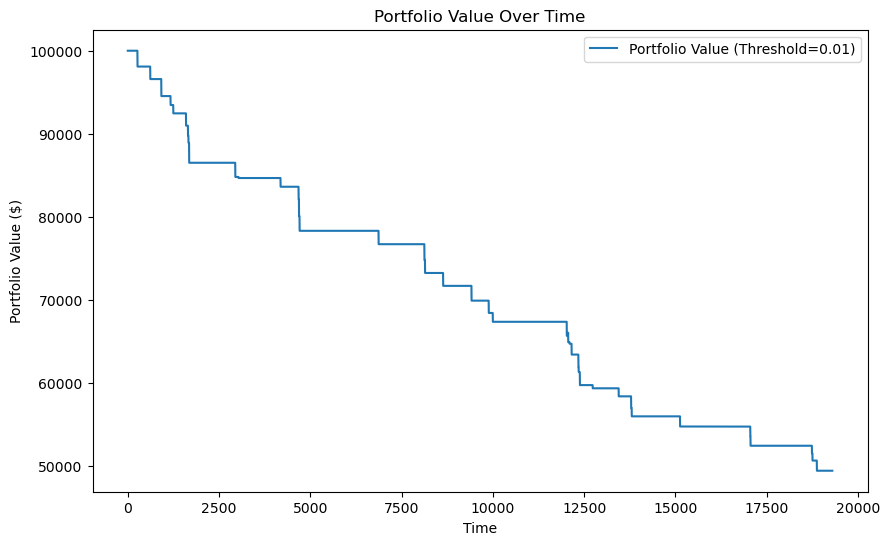

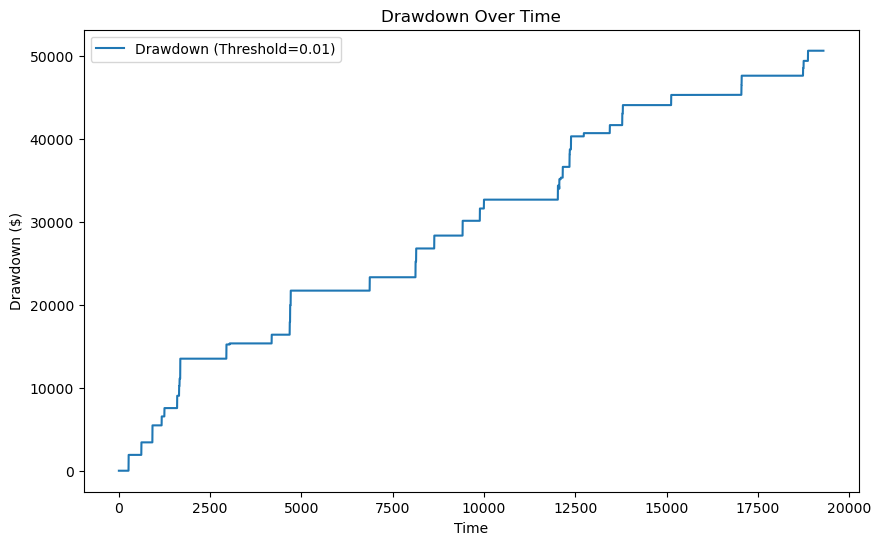

Backtesting Summary:
   threshold  total_profit  max_drawdown  trade_count  win_ratio  \
0       0.01    -50.613909     50.613909           42   0.047619   

   average_profit_per_trade  
0                 -1.205093  


In [19]:
# Add the lag features to predict_df using the new lags
predict_df = add_lag_features(predict_df, lags)

# Verify that all required features are present
required_features = ['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
                    [f'log_close/mean_{lag}' for lag in lags] + \
                    [f'log_return_{lag}' for lag in lags] + \
                    [f'mean_close/mean_{lag}' for lag in lags] + \
                    [f'mean_log_returns_{lag}' for lag in lags] + \
                    [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] + \
                    [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags] + \
                    ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 
                     'EMA_50', 'EMA_200', 'ATR', 'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 
                     'ADX', '+DI', '-DI']

# Check if all required features are present
missing_features = [col for col in required_features if col not in predict_df.columns]
if missing_features:
    print("Missing features:", missing_features)
    raise ValueError("predict_df is missing some required features. Ensure feature engineering is consistent.")

# Prepare prediction dataset
X_predict = predict_df[required_features]

# Predict using the optimized model
df_pred = predict_df.copy()
df_pred['Predict'] = final_model.predict(X_predict)

# Run backtesting with the updated predictions
results_df, trades_df = backtest(df_pred)
print("Backtesting Summary:")
print(results_df)

# Save trades to CSV for further analysis
trades_df.to_csv("trades_summary_v2.csv", index=False)

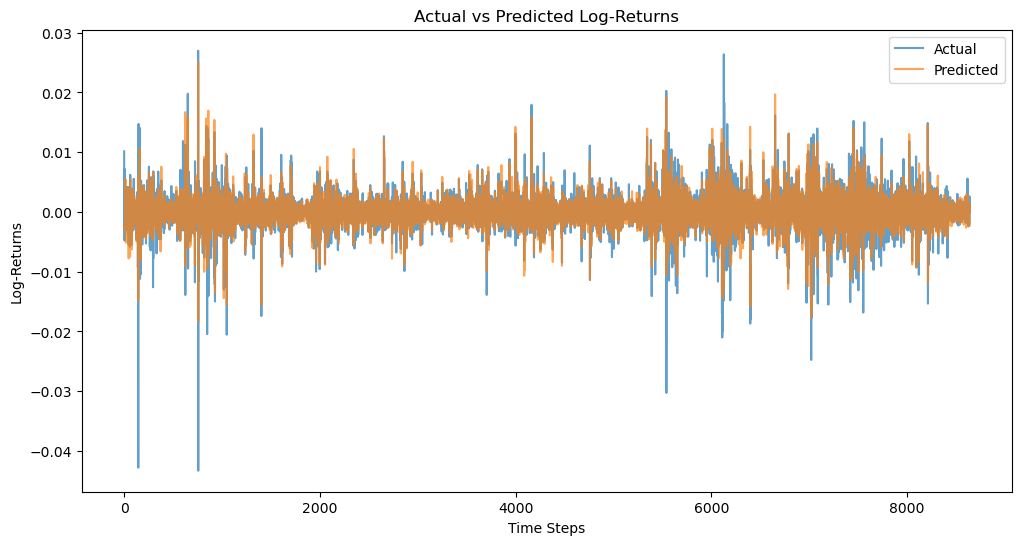

In [20]:
import matplotlib.pyplot as plt

# Plot actual vs predicted log-returns
plt.figure(figsize=(12, 6))
plt.plot(y_valid.values, label='Actual', alpha=0.7)
plt.plot(final_preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Log-Returns")
plt.xlabel("Time Steps")
plt.ylabel("Log-Returns")
plt.show()

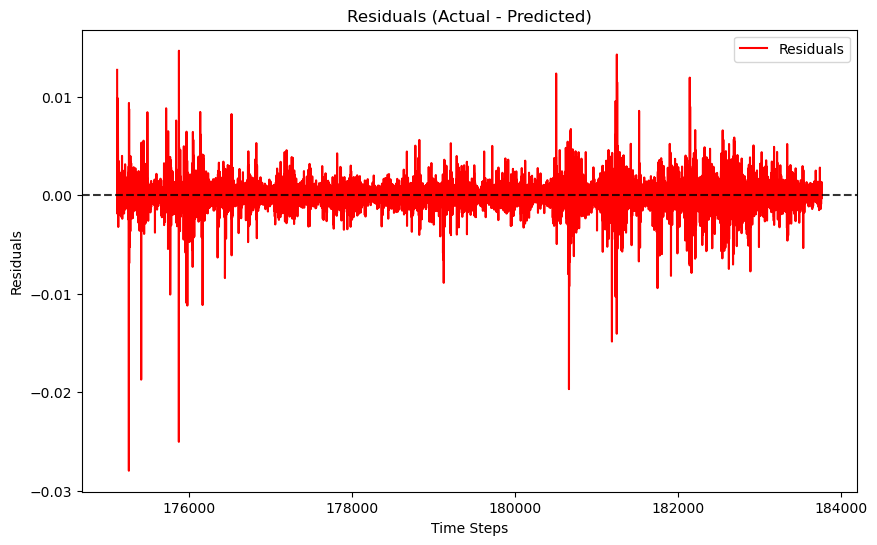

In [21]:
# Calculate residuals
residuals = y_valid - final_preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals", color='red')
plt.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.show()


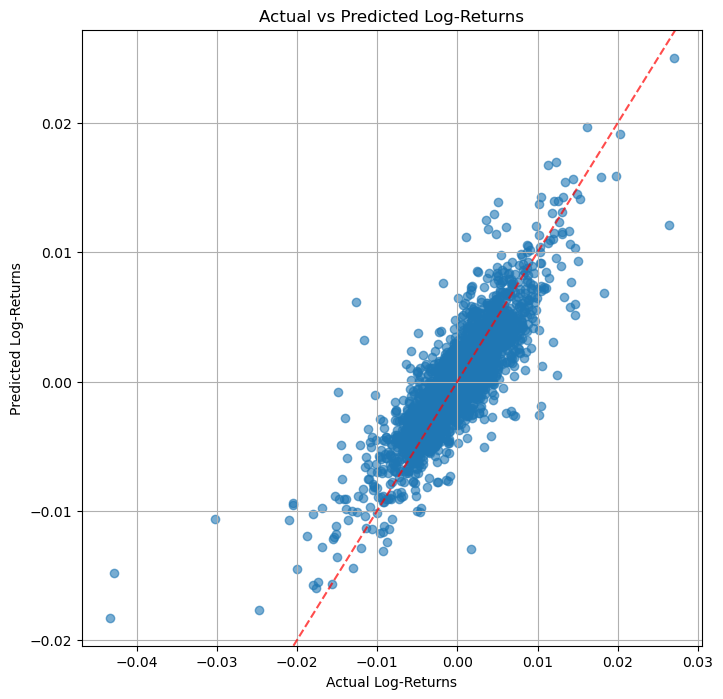

In [22]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_valid, final_preds, alpha=0.6)
plt.title("Actual vs Predicted Log-Returns")
plt.xlabel("Actual Log-Returns")
plt.ylabel("Predicted Log-Returns")
plt.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.7)
plt.grid()
plt.show()


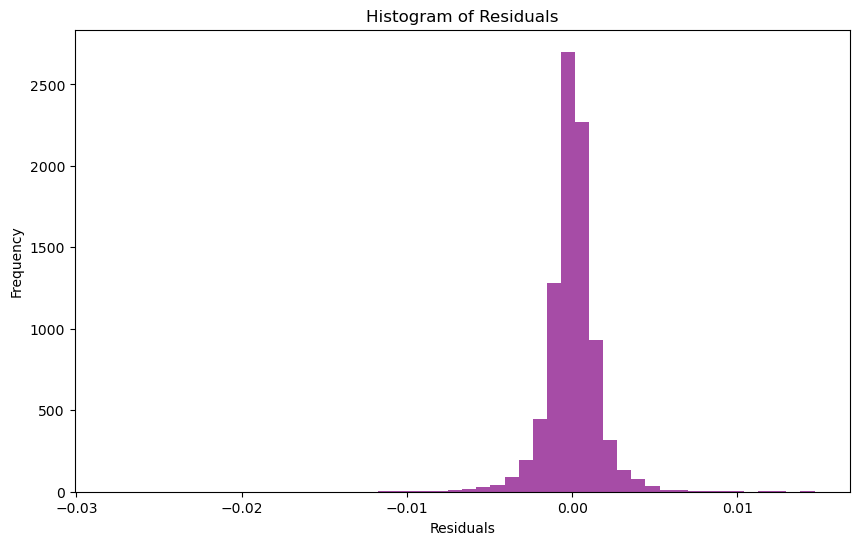

In [23]:
# Plot residual histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7, color='purple')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [24]:
# Calculate Sharpe Ratio
mean_return = np.mean(df_pred['Predict'])  # Predicted mean returns
std_dev_return = np.std(df_pred['Predict'])  # Standard deviation of returns
sharpe_ratio = mean_return / std_dev_return if std_dev_return != 0 else 0

print(f"Sharpe Ratio: {sharpe_ratio:.6f}")


Sharpe Ratio: -0.008277


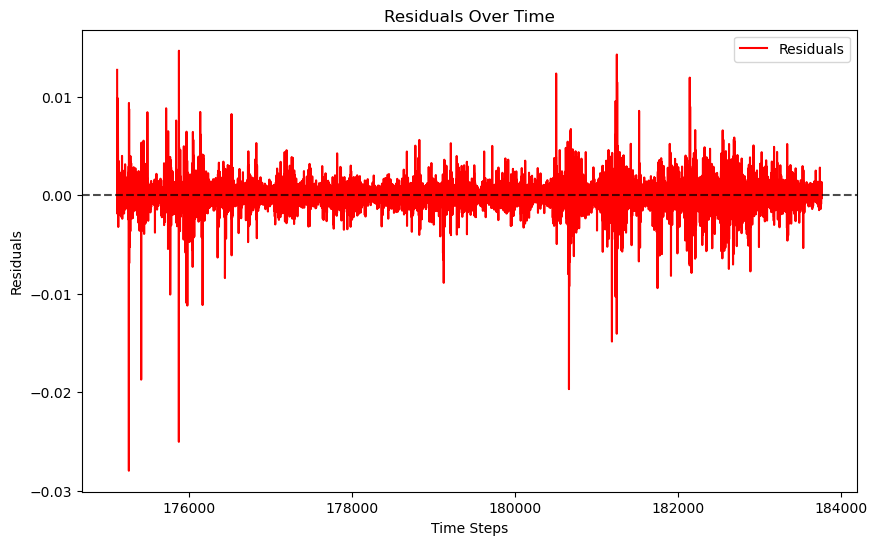

In [25]:
residuals = y_valid - final_preds
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals", color='red')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title("Residuals Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.show()
